In [1]:
# Import libraries for analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Putting CSV files into dataframe for analysis
products_df = pd.read_csv("/home/workspace/test/PRODUCTS.csv")
transactions_df = pd.read_csv("/home/workspace/test/TRANSACTION.csv")
users_df = pd.read_csv("/home/workspace/test/USER.csv")

In [3]:
# Script for Missing Values Heatmap visualizations 
# Convert date fields to datetime
date_cols = ["PURCHASE_DATE", "SCAN_DATE", "CREATED_DATE", "BIRTH_DATE"]
for col in date_cols:
    for df in [transactions_df, users_df]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

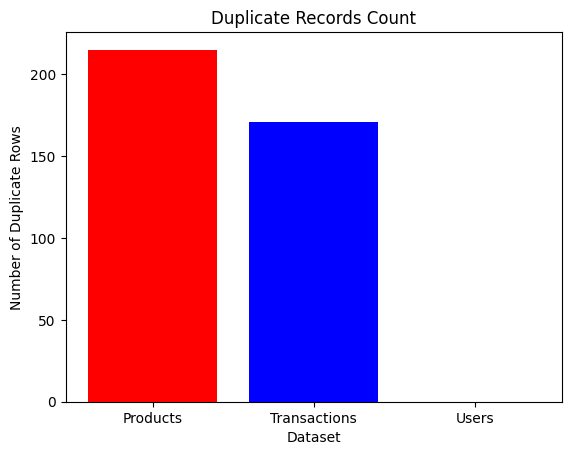

In [4]:
# Duplicate Records Count
duplicate_counts = {
    "Products": products_df.duplicated().sum(),
    "Transactions": transactions_df.duplicated().sum(),
    "Users": users_df.duplicated().sum(),
}
plt.bar(duplicate_counts.keys(), duplicate_counts.values(), color=['red', 'blue', 'green'])
plt.xlabel("Dataset")
plt.ylabel("Number of Duplicate Rows")
plt.title("Duplicate Records Count")
plt.show()


Data exploration is separated by the datasets (Product, Transaction & User) and analyzed for data quality issue and fields that pose challenge with additional findings for each respective dataset. 

## 1. Product dataset

#### Data Quality Issue: Missing Values

- CATEGORY_4 has the most missing values (~ 778k, ~ 92%) followed by MANUFACTURER(~ 226k, ~ 27%) and BRAND(~ 226k, ~ 27%).
- BARCODE has ~ 4k missing values, less than 1%. Important to note that without the barcode, those products details won't be linked to transactions table.

#### Potential Issues:

- CATEGORY_4 has sparse data, making it unclear how relevent this field is and unreliable.
- MANUFACTURER and BRAND have high missing values which will impact product analysis.
- Some entries have "PLACEHOLDER MANUFACTURER", indicating incomplete data.
- BARCODE is a float which may introduce precision error.
- Dataset has 215 duplicated rows and would need to remove duplicated records.

#### Additional Findings:

- BARCODE has ~ 841k unique values, indicating almost all products have a unique barcode.
- CATEGORY_1 has low unique values (27), suggesting a high level grouping (possibly division).

In [5]:
# Display datastructure & info on dataset
products_df.info()
products_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845441 non-null  object 
 1   CATEGORY_2    844128 non-null  object 
 2   CATEGORY_3    784986 non-null  object 
 3   CATEGORY_4    67459 non-null   object 
 4   MANUFACTURER  619078 non-null  object 
 5   BRAND         619080 non-null  object 
 6   BARCODE       841527 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.2+ MB


,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


In [6]:
# Display missing values percentage in dataset
products_null = products_df.isnull().mean()*100
products_null

CATEGORY_1       0.013128
CATEGORY_2       0.168411
CATEGORY_3       7.162895
CATEGORY_4      92.021898
MANUFACTURER    26.784160
BRAND           26.783923
BARCODE          0.476020
dtype: float64

In [7]:
# Display unique values in columns to identify anomalies
products_unique = products_df.nunique()
products_unique

CATEGORY_1          27
CATEGORY_2         121
CATEGORY_3         344
CATEGORY_4         127
MANUFACTURER      4354
BRAND             8122
BARCODE         841342
dtype: int64

In [8]:
# Display duplicate entries in dataset
products_duplicate = products_df.duplicated().sum()
products_duplicate

215

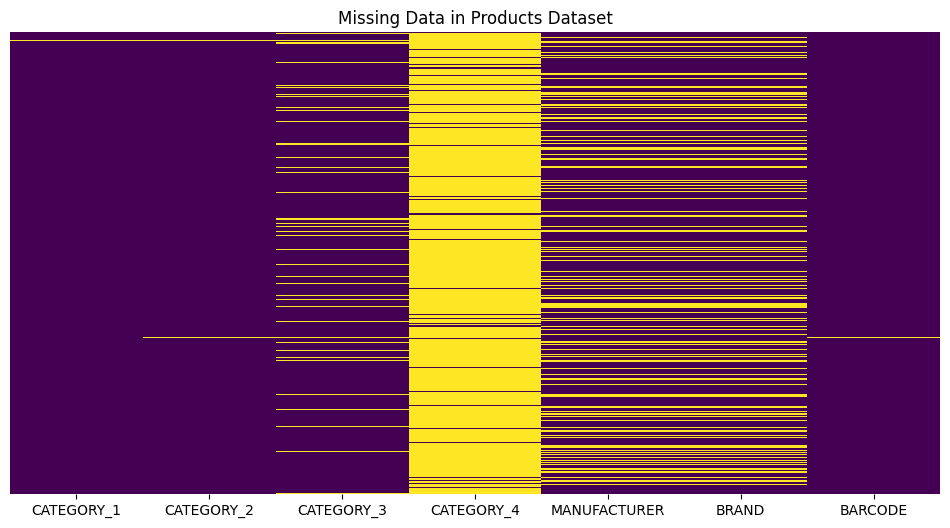

In [31]:
# Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(products_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Data in Products Dataset")
plt.show()

## 2. Transaction dataset

#### Data Quality Issue: Missing Values

- BARCODE is missing ~ 6k records, ~ 12% of transactions.
- FINAL_QUANTITY and FINAL_SALE have some non-numeric values like "zero".

#### Potential Issues:

- BARCODE missing tranactions would make it difficult to link purchases to specific products.
- FINAL_QUANTITY and FINAL_SALE should be numeric values but have text values like "zero". It would need to be standardized.
- SCAN_DATE has timestamp format which might require conversion for analysis.
- Dataset has 171 duplicated rows and would need to remove duplicated records.

#### Additional Findings:

- STORE_NAME has 954 unique values, suggesting high store diversity.
- USER_ID has ~ 18k unique user, meaning many users have multiple transactions.

In [10]:
# Display datastructure & info on dataset
transactions_df.info()
transactions_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   RECEIPT_ID      50000 non-null  object             
 1   PURCHASE_DATE   50000 non-null  datetime64[ns]     
 2   SCAN_DATE       50000 non-null  datetime64[ns, UTC]
 3   STORE_NAME      50000 non-null  object             
 4   USER_ID         50000 non-null  object             
 5   BARCODE         44238 non-null  float64            
 6   FINAL_QUANTITY  50000 non-null  object             
 7   FINAL_SALE      50000 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), object(5)
memory usage: 3.1+ MB


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539000+00:00,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206000+00:00,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813000+00:00,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468000+00:00,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549000+00:00,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [11]:
# Display missing values percentage in dataset
transactions_null = transactions_df.isnull().mean()*100
transactions_null

RECEIPT_ID         0.000
PURCHASE_DATE      0.000
SCAN_DATE          0.000
STORE_NAME         0.000
USER_ID            0.000
BARCODE           11.524
FINAL_QUANTITY     0.000
FINAL_SALE         0.000
dtype: float64

In [12]:
# Display unique values in columns to identify anomalies
transactions_unique = transactions_df.nunique()
transactions_unique

RECEIPT_ID        24440
PURCHASE_DATE        89
SCAN_DATE         24440
STORE_NAME          954
USER_ID           17694
BARCODE           11027
FINAL_QUANTITY       87
FINAL_SALE         1435
dtype: int64

In [13]:
# Display duplicate entries in dataset
transactions_duplicate = transactions_df.duplicated().sum()
transactions_duplicate

171

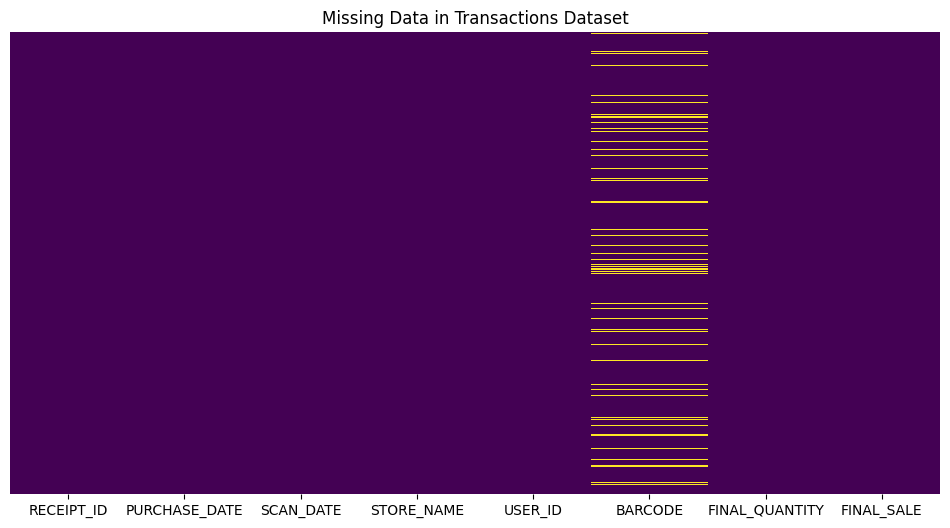

In [29]:
# Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(transactions_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Data in Transactions Dataset")
plt.show()

### 3. Users dataset

#### Data Quality Issue: Missing Values

- LANGUAGE has the most missing values (~ 35k, ~ 30%) followed by GENDER(~ 6k, ~ 6%), STATE(~ 5k, ~ 5%) and BIRTH_DATE(~ 4k, ~ 4%).

#### Potential Issues:

- LANGUAGE has high missing values, limiting demographic insights.
- BIRTH_DATE format may need conversion.
- Some users have missing gender and state information, limiting gender and geographic insights.
- STATE has 52 unique values, suggesting it contains both states and other location codes. 

In [15]:
# Display datastructure & info on dataset
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   ID            100000 non-null  object             
 1   CREATED_DATE  100000 non-null  datetime64[ns, UTC]
 2   BIRTH_DATE    96325 non-null   datetime64[ns, UTC]
 3   STATE         95188 non-null   object             
 4   LANGUAGE      69492 non-null   object             
 5   GENDER        94108 non-null   object             
dtypes: datetime64[ns, UTC](2), object(4)
memory usage: 4.6+ MB


,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54+00:00,2000-08-11 00:00:00+00:00,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55+00:00,2001-09-24 04:00:00+00:00,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18+00:00,1994-10-28 00:00:00+00:00,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22+00:00,NaT,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50+00:00,1972-03-19 00:00:00+00:00,PA,en,female


In [16]:
# Display missing values percentage in dataset
users_null = users_df.isnull().mean()*100
users_null

ID               0.000
CREATED_DATE     0.000
BIRTH_DATE       3.675
STATE            4.812
LANGUAGE        30.508
GENDER           5.892
dtype: float64

In [17]:
# Display unique values in columns to identify anomalies
users_unique = users_df.nunique()
users_unique

ID              100000
CREATED_DATE     99942
BIRTH_DATE       54721
STATE               52
LANGUAGE             2
GENDER              11
dtype: int64

In [18]:
# Display duplicate entries in dataset
users_duplicate = users_df.duplicated().sum()
users_duplicate

0

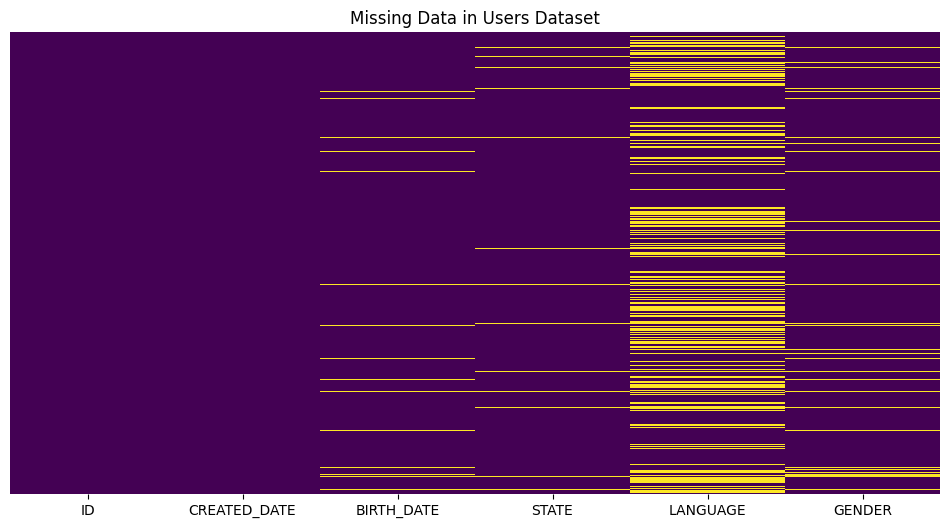

In [28]:
# Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(users_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Data in Users Dataset")
plt.show()